# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


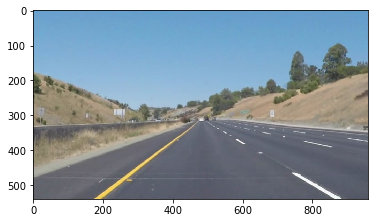

In [2]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math
from numpy import ones,vstack
from numpy.linalg import lstsq

saved_instance = np.array([[[2,3,4,5]],[[3,4,5,6]]])

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def build_vertices(img):
    """Builds vertices based on image size"""
    imshape = img.shape
    x, y, z = img.shape
    if x < 575 and y < 1000:
        vertices = vertices = np.array([[(130,imshape[0]),(430, 350), (530, 350), (900,imshape[0])]], dtype=np.int32)
        size = 'small'
    else:
        vertices = vertices = np.array([[(250,630), (570, 475), (775, 475), (1150,630)]], dtype=np.int32)
        size = 'big'
    return vertices, size
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_previous(**kwargs):
    if 'right' in kwargs:
        x1,y1,x2,y2 = saved_instance[0][0]
        right_lane = np.array([x1,y1,x2,y2],ndmin=2)
        return right_lane
    elif 'left' in kwargs:
        x1,y1,x2,y2 = saved_instance[1][0]
        left_lane = np.array([x1,y1,x2,y2],ndmin=2)
        return left_lane
        
def get_line_equation(x1,y1,x2,y2):
    x_coords = [x1, x2]
    y_coords = [y1, y2]
    A = vstack([x_coords, ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    return m, c
    
def extrapolate(test, size):
    lanes_adder = []
    if size == 'small':
        lower_y = 530
        upper_y = 340
    elif size == 'big':
        lower_y = 665
        upper_y = 450
    for line in test:
        for x1,y1,x2,y2 in line:
            m, c = get_line_equation(x1,y1,x2,y2)
            y1 = lower_y
            x1 = int(round((y1-c)/m))
            y2 = upper_y
            x2 = int(round((y2-c)/m))
            lane = np.array([x1,y1,x2,y2],ndmin=2)
            lanes_adder.append(lane)
    r_lane = np.asarray(lanes_adder[0])
    l_lane = np.asarray(lanes_adder[1])
    final_lanes = np.array([r_lane,l_lane])
    return final_lanes

def check_intersection(final_lane) :
    p0 = [final_lane[0][0][0], final_lane[0][0][1]]
    p1 = [final_lane[0][0][2], final_lane[0][0][3]]
    p2 = [final_lane[1][0][0], final_lane[1][0][1]]
    p3 = [final_lane[1][0][2], final_lane[1][0][3]]
    s10_x = p1[0] - p0[0]
    s10_y = p1[1] - p0[1]
    s32_x = p3[0] - p2[0]
    s32_y = p3[1] - p2[1]
    denom = s10_x * s32_y - s32_x * s10_y
    if denom == 0 : return False # collinear
    denom_is_positive = denom > 0
    s02_x = p0[0] - p2[0]
    s02_y = p0[1] - p2[1]
    s_numer = s10_x * s02_y - s10_y * s02_x
    if (s_numer < 0) == denom_is_positive : return False # no collision
    t_numer = s32_x * s02_y - s32_y * s02_x
    if (t_numer < 0) == denom_is_positive : return False # no collision
    if (s_numer > denom) == denom_is_positive or (t_numer > denom) == denom_is_positive : return False # no collision
    # collision detected
    return True

def draw_lines_minmax(img, lines, size, thickness=2, color=[255, 0, 0]):
    
    error_found = False
    slope_threshold = 0.4
    right_adder = []
    left_adder = []
    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope > slope_threshold:
                    right_adder.extend(line)
                elif slope < -slope_threshold:
                    left_adder.extend(line)
    except TypeError:
        error_found = True
        right_lane = get_previous(right='')
        left_lane = get_previous(left='')
        print ("Neither of the lanes were formed")
    else:
        try:
            right_lines = np.asarray(right_adder)
            r_min = np.argmin(right_lines,axis=0)[0]
            r_max = np.argmax(right_lines,axis=0)[2]
            right_lane = np.array([right_lines[r_min][0],right_lines[r_min][1],right_lines[r_max][2],right_lines[r_max][3]],ndmin=2)
            x1,y1,x2,y2 = right_lane[0]
            slope = (y2-y1)/(x2-x1)
            if -slope_threshold < slope < slope_threshold:
                error_found = True
                right_lane = get_previous(right='')
        except ValueError as e:
            print (e)
            print ("Right lane was not formed due to lack of enough valid datapoints generated from hough transform.")
            error_found = True
            right_lane = get_previous(right='')
        try:
            left_lines = np.asarray(left_adder)
            l_min = np.argmin(left_lines,axis=0)[0]
            l_max = np.argmax(left_lines,axis=0)[2]
            left_lane = np.array([left_lines[l_min][0],left_lines[l_min][1],left_lines[l_max][2],left_lines[l_max][3]],ndmin=2)
            x1,y1,x2,y2 = left_lane[0]
            slope = (y2-y1)/(x2-x1)
            if -slope_threshold < slope < slope_threshold:
                error_found = True
                left_lane = get_previous(left='')
        except ValueError as e:
            print (e)
            print ("Left lane was not formed due to lack of enough valid datapoints generated from hough transform.")
            error_found = True
            left_lane = get_previous(left='')
    test_lanes = np.array([right_lane,left_lane])
    final_lanes = extrapolate(test_lanes, size)
    if check_intersection(final_lanes):
        right_lane = get_previous(right='')
        left_lane = get_previous(left='')
        test_lanes = np.array([right_lane,left_lane])
        final_lanes = extrapolate(test_lanes, size)
        print ("Lines intersect")
    for line in final_lanes:
        for x1,y1,x2,y2 in line:   
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return final_lanes
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, size, thickness=2):
    """Returns an image with hough lines drawn."""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    final_lanes = draw_lines_minmax(line_img, lines, size, thickness)
    return line_img, final_lanes

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """initial_img * α + img * β + λ"""
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



In [4]:
from scipy import ndimage, misc
def build_img_pipeline(image):
    global saved_instance
    print ("HIT")
    misc.imsave('fileName.jpg', image)
    image = ndimage.imread('fileName.jpg',0)
    gray = (grayscale(image))
    g_blur = gaussian_blur(gray, 3)
    canned = canny(g_blur, 60, 120)
    vertices, size = build_vertices(image)
    sliced = region_of_interest(canned, vertices)
    houghed, saved_instance = hough_lines(sliced, 2, 1, 10, 12, 3, size, 20)
    lines_edges = weighted_img(houghed, image)
    return lines_edges

## Test on Videos

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
import imageio
imageio.plugins.ffmpeg.download()
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return build_img_pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos/solidWhiteRight_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(3,6)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left.

In [ ]:
yellow_output = 'test_videos/solidYellowLeft_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Finally on a more challenging video.

In [ ]:
challenge_output = 'test_videos/challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

~~ *Fin* ~~